In [256]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
from IPython.core.pylabtools import figsize
figsize(15, 7) 

#dataset_train = pd.read_csv('./dataset/THGBNKLAK1TS301_Memory Used (percentage)_Oct_2020.csv')  # 讀取訓練集
dataset_train = pd.read_csv('./dataset/ATKH_Oplus_TWGKHHPSK1MSB04_memory_usage_2020_10.csv')  # 讀取訓練集
#dataset_train = dataset_train.dropna(axis=0)
dataset_train = dataset_train[::-1].reset_index(drop=True) 

train_count = int(len(dataset_train)*0.8)
test_count = len(dataset_train)-train_count
training_set = dataset_train.iloc[:train_count, 3:4].values*1/100 # 取「Open」欄位值

#dataset_test = pd.read_csv('./dataset/ATBK_test.csv')
testing_set = dataset_train.iloc[train_count:, 3:4].values*1/100

#dataset_total = pd.concat((dataset_train['Value'], dataset_test['Value']), axis = 0)
#inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs) # Feature Scaling


In [257]:
dataset_train

,Date,time,Allocate memory,%used
0,2020/10/1,00:00:45,1601481645,34.8176
1,2020/10/1,00:03:45,1601481825,34.4525
2,2020/10/1,00:06:45,1601482005,35.1097
3,2020/10/1,00:09:46,1601482186,37.3601
4,2020/10/1,00:12:45,1601482365,38.7265
...,...,...,...,...
14873,2020/10/31,23:45:45,1604159145,29.2647
14874,2020/10/31,23:48:45,1604159325,29.1402
14875,2020/10/31,23:51:46,1604159506,29.1743
14876,2020/10/31,23:54:45,1604159685,29.1521


In [258]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler,RobustScaler


#MinMaxScaler

#sc = MinMaxScaler(feature_range = (0, 1))
#sc_train = MinMaxScaler(feature_range = (0, 1))
#training_set_scaled = sc_train.fit_transform(training_set)

#sc_test = MinMaxScaler(feature_range = (0, 1))
#testing_set_scaled = sc_test.fit_transform(testing_set)


#RobustScaler

sc_train = RobustScaler(quantile_range=(25, 50))
training_set_scaled = sc_train.fit_transform(training_set)

sc_test = RobustScaler(quantile_range=(25, 50))
testing_set_scaled = sc_test.fit_transform(testing_set)

In [259]:
testing_set_scaled

array([[ 0.98069865],
       [ 0.69758686],
       [ 1.05706734],
       ...,
       [-0.61361173],
       [-0.63049803],
       [-0.76520813]])

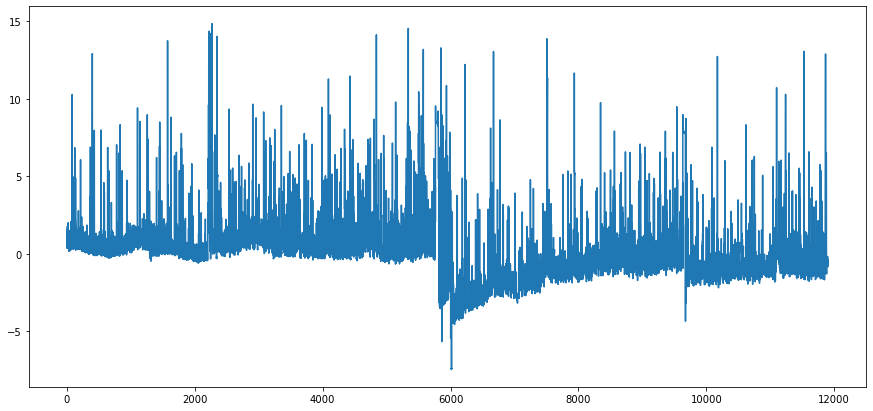

In [260]:
plt.plot(training_set_scaled)

In [261]:
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, 0])
        y_train.append(data[i:i+y_window_size, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    print(X_train.shape)
    samples = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    target = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
    
    return samples,target
    
X_train,y_train = gen_dataset(training_set,20,20)
X_test,y_test = gen_dataset(testing_set,20,20)

(594, 20)
(147, 20)


In [262]:
print(X_train.shape)
print(X_test.shape)

(594, 20, 1)
(147, 20, 1)


In [263]:
from keras.callbacks import ReduceLROnPlateau

rp = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)


In [264]:
X_train.shape[1]

20

In [265]:
UNIT = X_train.shape[1]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
L1 = GRU(UNIT,input_shape=(X_train.shape[1], X_train.shape[2]),unroll=True)(inputs)
L2 = Dropout(0.2)(L1)
L3 = RepeatVector(y_train.shape[1])(L2)
L4 = GRU(UNIT,return_sequences=True,unroll=True)(L3)
L5 = Dropout(0.2)(L4)
output = TimeDistributed(Dense(1))(L5)

model = Model(inputs=inputs, outputs=output)
encoder_model = Model(inputs=inputs, outputs=L3)
# output shape: (1, 1)
 # or use model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
gru_21 (GRU)                 (None, 20)                1320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 20, 20)            0         
_________________________________________________________________
gru_22 (GRU)                 (None, 20, 20)            2460      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 20)            0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 1)             21        
Total para

In [267]:
EPOCH = 50
BATCH = 10

In [268]:
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_split=0.1,callbacks=[rp],shuffle=False,verbose=1)

Train on 534 samples, validate on 60 samples
Epoch 1/50
534/534 [==============================] - 15s 29ms/step - loss: 0.1169 - val_loss: 0.0543
Epoch 2/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0663 - val_loss: 0.0457
Epoch 3/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0618 - val_loss: 0.0468
Epoch 4/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0571 - val_loss: 0.0421
Epoch 5/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0544 - val_loss: 0.0387
Epoch 6/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0523 - val_loss: 0.0402
Epoch 7/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0511 - val_loss: 0.0393
Epoch 8/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0489 - val_loss: 0.0380
Epoch 9/50
534/534 [==============================] - 2s 5ms/step - loss: 0.0481 - val_loss: 0.0401
Epoch 10/50
534/534 [==============================] 

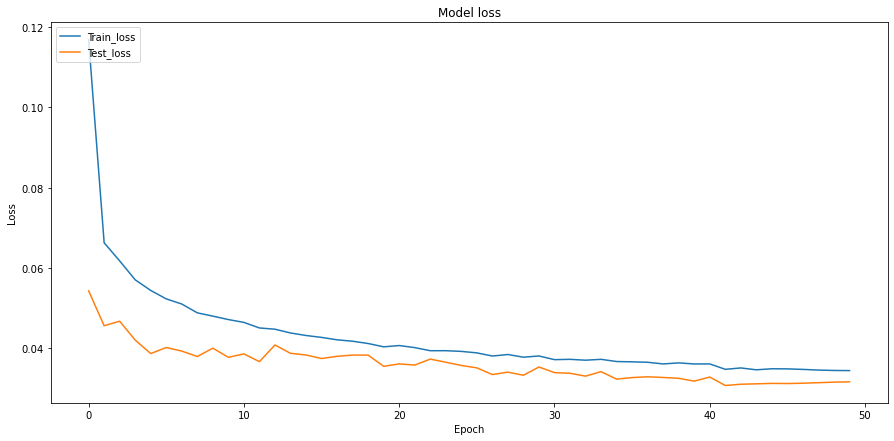

In [269]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Test_loss'], loc='upper left')
plt.show()

In [275]:
predicted_traffic = model.predict(X_test)

predicted_traffic = np.reshape(predicted_traffic,(-1,1))

#predicted_traffic = sc_train.inverse_transform(predicted_traffic)  # to get the original scale
predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

#plot_predicted_traffic = np.reshape(predicted_traffic,(-1,1))

In [276]:
testing_set

array([[0.312703],
       [0.308981],
       [0.313707],
       ...,
       [0.291743],
       [0.291521],
       [0.28975 ]])

In [277]:
testing_set.shape[0]-predicted_traffic.shape[0]

36

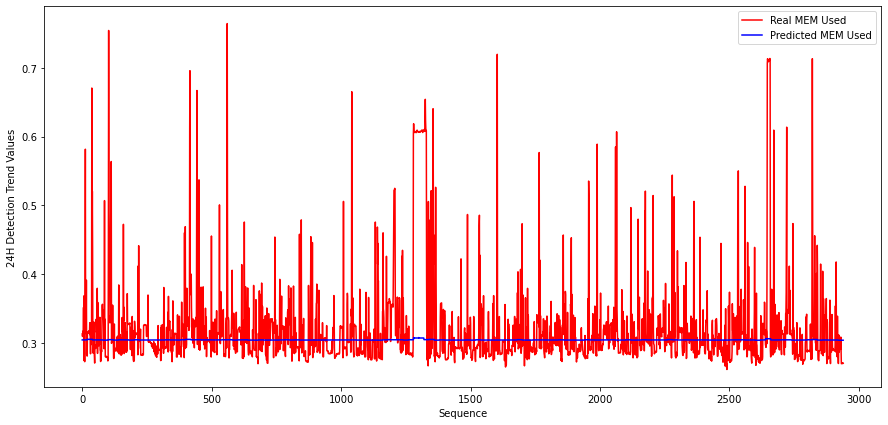

In [278]:


plt.plot(testing_set[:predicted_traffic.shape[0]],color = 'red', label = 'Real MEM Used')
plt.plot(predicted_traffic,color = 'blue', label = 'Predicted MEM Used')

#plt.axhline(y=30, xmin=0, xmax=predicted_traffic.shape[0],label = 'upper')
#plt.axhline(y=0.7, xmin=0, xmax=predicted_traffic.shape[0],label = 'low')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.legend()

In [279]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error

MAEScore = mean_absolute_error(testing_set[:predicted_traffic.shape[0]],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(testing_set[:predicted_traffic.shape[0]],predicted_traffic))

print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))

Test Score: 0.03 MAE
Test Score: 0.07 RMSE


In [234]:
from keras.utils import plot_model
plot_model(model, to_file='./model_plot/GRU_model1.png',show_shapes=True)

In [156]:
model.save("./model/MEM_use_model_best.h5")

In [158]:
for i in range(predicted_traffic.shape[0]):
    q_value = np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint')
    if q_value[2] >=30:
        print(q_value[2])

30.311609268188477
30.311609268188477
30.31193733215332
30.31666374206543
30.318483352661133
30.319111824035645
30.319278717041016
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.13224697113037
30.132166862487793
30.132097244262695
30.13205051422119
30.1320219039917
30.13200569152832
30.131997108459473
30.13199234008789
30.131990432739258
30.13198947906494
30.131988525390625


<function matplotlib.pyplot.show(close=None, block=None)>

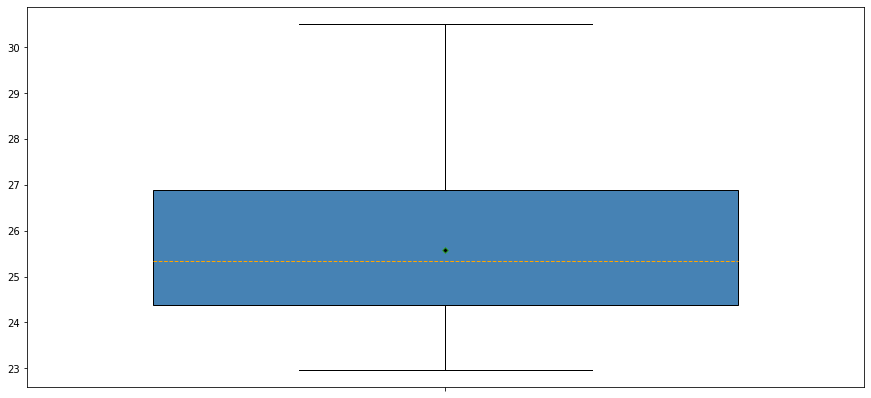

In [165]:
plt.boxplot(x=predicted_traffic,whis = 20,widths = 0.7,patch_artist = True,showmeans = True,boxprops = {'facecolor':'steelblue'}
            ,flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}
            ,meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}
            ,medianprops = {'linestyle':'--','color':'orange'},labels = [''])



plt.show


In [166]:
for i in range(predicted_traffic.shape[0]-20):
    #print(i,i+20)
    max_value = np.max(np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint'))
    if max_value >= 30:
        print(max_value)

30.311609268188477
30.311609268188477
30.31193733215332
30.31666374206543
30.318483352661133
30.319111824035645
30.319278717041016
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.13224697113037
30.132166862487793
30.132097244262695
30.13205051422119
30.1320219039917
30.13200569152832
30.131997108459473
30.13199234008789
30.131990432739258
30.13198947906494
30.131988525390625
